## Reddit Philippines Random Discussion Threads: A Just-for-fun Exploration

Having been inactive on Facebook for quite some time now, I've turned to the [Philippines subreddit](https://www.reddit.com/r/Philippines/) for my periodic dose of local fun stuff. The sub itself has many interesting posts, though I have noticed some complaints about it being too political lately. (Reddit is accused of being partial to one side, and to confirm that is another interesting story.) Mostly 'spared' from political posts is the Random Discussion thread. An RD is generally a mix of rants, jokes, what-i-did-today, what-did-you-eat, and please-help-me type of posts, like a Facebook feed of people you don't know - with less selfies. (There are selfie threads occasionally.) Soon, it would be four years since the first RD, so I thought, why not look back and explore the data? Churn out some statistics for awards of some virtual sort, or maybe even learn how something becomes meme status. This won't change the world or anything, just fun practice.

In [142]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
#from plotly.offline import iplot, init_notebook_mode
#import plotly.graph_objs as go

#import sys
import os
from datetime import datetime, date, time, timedelta

import praw
from prawcore.exceptions import RequestException
import pprint

sns.set_style("white")
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)
#init_notebook_mode(connected=True)


Good thing there's a Python wrapper for the Reddit API that makes data extraction easier. Input configuration settings here (see [PRAW docs](http://praw.readthedocs.io/en/latest/getting_started/authentication.html#oauth) for instructions)

In [2]:
reddit = praw.Reddit(client_id='##########',
                     client_secret='##########',
                     user_agent='##########')

A preliminary search revealed that the first RD was posted 2014-03-12. We'll use this to limit our search horizon. 

In [3]:
inception =  datetime(2014, 3, 12)
today = datetime.today()
today_beginning = datetime.combine(date.today(), time())
print(today_beginning)

2018-02-13 00:00:00


We then define a function that specifies the information we'd like to extract for a submission (i.e. the RD thread). For some reason, downs are always 0 and score = ups so we don't include ups and downs anymore. 

In [60]:
def add_submission (submission):

    addl_submission = {'id':str(submission.id),
                       #'submission':submission,
                       'title':submission.title,
                       'author':submission.author,
                       'created': submission.created,
                       'permalink':submission.permalink,
                       'n_comments':submission.num_comments,
                       'score':submission.score
                       #'ups':reddit.submission(id=sub_id).ups,
                       #'downs':reddit.submission(id=sub_id).downs
    }
    
    return addl_submission

In [61]:
submissions_file = 'submissionsDF.csv'
comments_file = 'commentsDF.csv'

The idea is to save a submissions data file locally so we don't have to download the data each time. We search for submissions with the string "random discussion" the first time to get the bulk of the data and update incrementally if we want to. (A daily update should yield 4 submissions in the search - those from yesterday.)

In [63]:
if os.path.isfile(submissions_file):
    with open(submissions_file, 'r') as f:
        submissionsDF = pd.read_csv(f, lineterminator='\n', converters={'id': lambda x: str(x)}) #ensure id is read as string
        search_start_date = pd.to_datetime(submissionsDF['created'], unit = 's').dt.date.max()
        search_start = datetime.combine(search_start_date, time())
        print('Old submissions file found. Will start search from {}'.format(search_start))
    
else:
    submissionsDF = pd.DataFrame()
    search_start = inception
    print('No submissions file found. Will start search from {}'.format(search_start))

# From PRAW docs:
# The value of submission.num_comments may not match up 100% with the number of comments extracted via PRAW. 
# This discrepancy is normal as that count includes deleted, removed, and spam comments.

search_terms = "random discussion"
print('Searching for \'{}\' between {} and {}'.format(search_terms,
                                                      search_start,
                                                     today_beginning
                                                     )
     )


new_submissions = [add_submission(submission)                       
               for submission in reddit.subreddit('Philippines').submissions(start = search_start.timestamp(), 
                                                                              end = today_beginning.timestamp(), 
                                                                              extra_query = '(or title:\'{}\')'.format(search_terms))]
print('Done.')

new_submissionsDF = pd.DataFrame(new_submissions)

submissionsDF = pd.concat([new_submissionsDF, submissionsDF])
submissionsDF = submissionsDF[~submissionsDF['id'].duplicated()]
submissionsDF = submissionsDF.set_index('id')
submissionsDF.to_csv(submissions_file)

submissionsDF['date'] = pd.to_datetime(submissionsDF['created'],unit='s').dt.date
print('Number of rows from search: {}'.format(new_submissionsDF.shape[0]))
print('Total number of submissions: {}'.format(submissionsDF.shape[0]))
submissionsDF.head()

Old submissions file found. Will start search from 2018-02-12 00:00:00
Searching for 'random discussion' between 2018-02-12 00:00:00 and 2018-02-13 00:00:00
Done.
Number of rows from search: 4
Total number of submissions: 3280


,author,created,n_comments,permalink,score,title,date
id,,,,,,,
7x1ngd,the_yaya,1.518480e+09,230,/r/Philippines/comments/7x1ngd/nightly_random_...,10,"Nightly random discussion - Feb 12, 2018",2018-02-12
7wzqfd,the_yaya,1.518458e+09,1105,/r/Philippines/comments/7wzqfd/evening_random_...,34,"Evening random discussion - Feb 12, 2018",2018-02-12
7wy3pa,the_yaya,1.518437e+09,1606,/r/Philippines/comments/7wy3pa/afternoon_rando...,24,"Afternoon random discussion - Feb 12, 2018",2018-02-12
7wvwxd,the_yaya,1.518415e+09,1289,/r/Philippines/comments/7wvwxd/daily_random_di...,45,"Daily random discussion - Feb 12, 2018",2018-02-12
7wtifm,the_yaya,1.518393e+09,382,/r/Philippines/comments/7wtifm/nightly_random_...,12,"Nightly random discussion - Feb 11, 2018",2018-02-11


A cursory glance at the dataset.

In [64]:
submissionsDF.isnull().any()

author        False
created       False
n_comments    False
permalink     False
score         False
title         False
date          False
dtype: bool

In [65]:
submissionsDF.describe()

,created,n_comments,score
count,3.280000e+03,3280.000000,3280.000000
mean,1.469361e+09,523.985976,21.548476
std,3.506648e+07,370.614531,12.109900
min,1.394606e+09,5.000000,0.000000
25%,1.439435e+09,229.000000,13.000000
50%,1.474761e+09,418.500000,20.000000
75%,1.500881e+09,752.000000,29.000000
max,1.518480e+09,3729.000000,246.000000


We need to drop the threads that aren't valid RDs (they just happened to mention "random discussion" in their title). This is easy for threads made by a bot because the title formatting is consistent. But when did the bot u/the_yaya start anyway?

In [66]:
yaya_start = pd.to_datetime(submissionsDF[submissionsDF['author'].astype(str)== 'the_yaya']['created'].min(),unit='s')
print('Yaya started {}'.format(yaya_start))
#submissionsDF[(submissionsDF['date'] > (yaya_start - timedelta(days=2))) &
#              (submissionsDF['date'] < (yaya_start + timedelta(days=1)))
#             ]

Yaya started 2014-04-23 07:52:16


And before the bot? 

In [67]:
print('Author(s) before the bot: {}'.format(submissionsDF[submissionsDF['date'] < yaya_start.date()]['author'].unique()))
submissionsDF[submissionsDF['date'] < yaya_start.date()]['title']

Author(s) before the bot: ['willtraveltoindia']


id
23mn8p                       Random daily discussion thread
23jybr            Random daily discussion thread - 04/21/14
23h39u            Random daily discussion thread - 04/20/14
23eevw            Random daily discussion thread - 04/19/14
23bb7m            Random daily discussion thread - 04/18/14
238dt9            Random daily discussion thread - 04/17/14
2357rb            Random daily discussion thread - 04/16/14
231xm6            Random daily discussion thread - 04/15/14
22yptp            Random daily discussion thread - 04/14/14
22tnk8    Random discussion thread - Weekend Edition (04...
22qow7            Random daily discussion thread - 04/11/14
22nlu2                   Random daily discussion - 04/10/14
22kj19            Random daily discussion thread - 04/09/14
22h8xk            Random daily discussion thread - 04/08/14
22dz62            Random daily discussion thread – 04/07/14
2288e0    Random discussion thread - Weekend Edition (04...
225i4z            Random daily discus

All submissions are valid and posted by /u/willtraveltoindia even though the formatting varies. Nothing to drop here, though we must note that some are 'weekend editions' that span two days. This also means that there will be missing threads every week from 2014-03-16 to 2014-04-13.

Once the bot kicked in, RDs should have been authored by the_yaya and the title formatting should have been consistent. But it seems like the bot is down sometimes and users submit RDs in its behalf while trying to keep the title format the same (but not quite all the time). 

In [68]:
non_bot_threadsDF = submissionsDF[(submissionsDF['author'].astype(str) != 'the_yaya') &
              (submissionsDF['date'] > yaya_start.date())
             ]
non_bot_threadsDF.head(10)

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
7tzq2u,NotAikoYumi,1.517331e+09,36,/r/Philippines/comments/7tzq2u/tinola_with_pap...,32,Tinola with Papaya vs. Sayote - The War to end...,2018-01-30
7tyn2y,SayoteGod,1.517317e+09,98,/r/Philippines/comments/7tyn2y/shitpost_ang_tu...,246,[shitpost] Ang tunay na nangyayari sa random d...,2018-01-30
7txb8i,thehandsomejj,1.517304e+09,153,/r/Philippines/comments/7txb8i/shitpost_rph_ra...,191,[Shitpost] r/PH Random Discussions in a nutshell,2018-01-30
7t4pqg,mydickisasalad,1.517005e+09,35,/r/Philippines/comments/7t4pqg/anyone_else_not...,46,Anyone else noticing a lot of downvoted commen...,2018-01-26
7o6fbi,sendcordonbleu,1.515133e+09,800,/r/Philippines/comments/7o6fbi/daily_random_di...,54,"Daily random discussion - Jan 05, 2018",2018-01-05
7312ju,AnonPrince,1.506643e+09,160,/r/Philippines/comments/7312ju/nightly_random_...,29,"Nightly Random Discussion - September 28, 2017",2017-09-29
6tteub,adrian1920,1.502824e+09,10,/r/Philippines/comments/6tteub/random_discussi...,2,Random Discussion Questions,2017-08-15
6bx3n0,evilphotosynthesis,1.495152e+09,186,/r/Philippines/comments/6bx3n0/nightly_random_...,18,"Nightly random discussion - May 18, 2017",2017-05-19
6bv8l3,starscar12,1.495131e+09,1009,/r/Philippines/comments/6bv8l3/evening_random_...,41,"Evening random discussion - May 18, 2017",2017-05-18


At the very least, they use some variation of *xxxx random discussion* followed by a date (albeit in various formats) in the title. This differentiates the user-posted RDs from the threads only mentioning "random discussion" in their titles but are not actually RD threads.  

In [69]:
valid_RD_title = 'random discussion.*(?:(?:[0-9]+\/)|(?:[0-9]+\,))'

ids_to_drop = non_bot_threadsDF[~non_bot_threadsDF.title.str.contains(valid_RD_title, case=False)].index
ids_to_keep = set(submissionsDF.index) - set(ids_to_drop)

print("No. of rows before dropping: {}".format(submissionsDF.shape[0]))
#submissionsDF.loc[ids_to_drop]


No. of rows before dropping: 3280


In [70]:
submissionsDF = submissionsDF.loc[ids_to_keep]
print("No. of rows before dropping: {}".format(submissionsDF.shape[0]))

No. of rows before dropping: 3270


Let's do a sanity check if we got threads for every day in the range.

In [71]:
from dateutil.rrule import rrule, DAILY

day_list = list(rrule(freq=DAILY, dtstart=inception, until=today_beginning-timedelta(days=1)))
days_in_df = submissionsDF['date'].values
missing_days = [day.date() for day in day_list  if day.date() not in days_in_df]
print(missing_days)

[datetime.date(2014, 3, 16), datetime.date(2014, 3, 18), datetime.date(2014, 3, 23), datetime.date(2014, 3, 30), datetime.date(2014, 4, 6), datetime.date(2014, 4, 13), datetime.date(2014, 6, 16)]


We know why most of the threads are missing (recall weekend editions). For the rest (2014-03-18 and 2014-06-16), it turns out that somehow, reddit search did not catch them (probably because the user/s who posted them have deleted their account/s). We'll add them manually by using the thread id from Google search. 

In [72]:
submission_ids = ['20otoa','288ikk']
addl_submissions = [add_submission(reddit.submission(id=sub_id)) for sub_id in submission_ids]
addl_submissionsDF = pd.DataFrame(addl_submissions).set_index('id')
addl_submissionsDF['date'] = pd.to_datetime(addl_submissionsDF['created'],unit='s').dt.date
addl_submissionsDF.head()

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
20otoa,None,1.395141e+09,185,/r/Philippines/comments/20otoa/random_daily_di...,21,Random daily discussion thread - 03/18/14,2014-03-18
288ikk,None,1.402903e+09,162,/r/Philippines/comments/288ikk/daily_random_di...,7,"Daily random discussion - Jun 16, 2014",2014-06-16


In [73]:
submissionsDF = pd.concat([submissionsDF, addl_submissionsDF])
submissionsDF = submissionsDF[~submissionsDF.index.duplicated(keep='first')]
print(submissionsDF.shape)

(3272, 7)


Run the daily check again to see if we only have the 'weekend edition' threads left.

In [74]:
days_in_df = submissionsDF['date'].values
missing_days = [day.date() for day in day_list  if day.date() not in days_in_df]
print(missing_days)

[datetime.date(2014, 3, 16), datetime.date(2014, 3, 23), datetime.date(2014, 3, 30), datetime.date(2014, 4, 6), datetime.date(2014, 4, 13)]


Because of 'domain expertise' (heh) we know to expect three 'regions': 
1. One RD per day 
2. Two RDs per day from 2014-10-10
3. Four RDs per day from 2017-04-08

This would be apparent after the count is plotted anyway. The dates were inferred from the extracted data and verified manually by visiting the threads and confirming the transition. (There is usually an announcement about the split.)

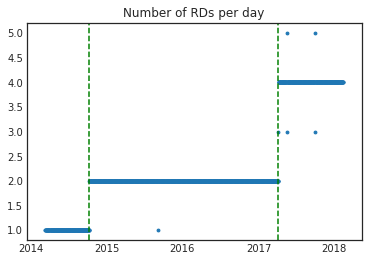

In [75]:
byDateDF = pd.DataFrame(submissionsDF[['date','created']]).groupby('date').count()
byDateDF.columns = ['num_RD']

plt.scatter(x=byDateDF.index, y=byDateDF['num_RD'], s = 8)

years = mdates.YearLocator()   
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set_title('Number of RDs per day')


#RD splits
plt.axvline(pd.to_datetime('2014-10-09'), linestyle = '--', color='g')
plt.axvline(pd.to_datetime('2017-04-07'), linestyle = '--', color='g')

plt.show()

There are still quite a few outliers given our expected regions. Let's check them out.

In [77]:
odd_dates = byDateDF[(byDateDF.index > datetime(2014,10,10).date()) &
                     (byDateDF['num_RD'] % 2 != 0)].index
print(odd_dates)
#submissionsDF[submissionsDF['date'].isin(odd_dates)]

Index([2015-09-04, 2017-04-07, 2017-05-18, 2017-05-19, 2017-09-28, 2017-09-29], dtype='object', name='date')


Upon checking the threads for 2017-04-07, we find out that it is a transition day where there were 3 RDs intentionally, before the moderators made 4 per day. So there's nothing to drop nor add. Just take note.

On the other hand, we see that the Nightly RD for 2017-09-28 (which the_yaya omitted posting) is user-posted and crossed over midnight to 2017-09-29. The same goes for the pair 2015-05-18 and 2017-05-19. We manually adjust these by moving the latter ones 10 minutes ahead. But we keep the 'created' field unchanged so we have access to the original and we can run the code over and over without nudging every time.  





In [78]:
nudge_ids = ['6bx3n0', '7312ju']

for nudge_id in nudge_ids:
    nudged_ts = submissionsDF.loc[nudge_id]['created'] - 600
    submissionsDF.at[nudge_id,'date'] = pd.to_datetime(nudged_ts, unit='s').date()

submissionsDF.loc[nudge_ids]

,author,created,n_comments,permalink,score,title,date
id,,,,,,,
6bx3n0,evilphotosynthesis,1.495152e+09,186,/r/Philippines/comments/6bx3n0/nightly_random_...,18,"Nightly random discussion - May 18, 2017",2017-05-18
7312ju,AnonPrince,1.506643e+09,160,/r/Philippines/comments/7312ju/nightly_random_...,29,"Nightly Random Discussion - September 28, 2017",2017-09-28


Only 2015-09-0 remains unresolved. The last top level comment on the daily thread for 2015-09-04 was posted at 5:59 PM which indicates that there must be a nightly thread somewhere, but can't find it, even on Google. 

In [79]:
outlier = reddit.submission(id='3jjinu')
outlier.comments.replace_more(limit=None)
comment_datetime = [comment.created for comment in outlier.comments.list()]

print('Last comment posted on {}'.format(pd.to_datetime(max(comment_datetime),unit='s')))

Last comment posted on 2015-09-05 05:59:56


### Exploring the submissions dataset

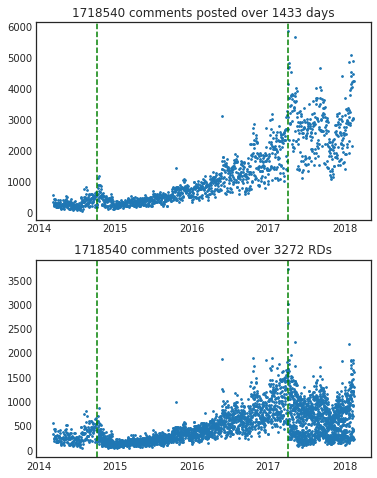

In [80]:
comment_per_day = submissionsDF[['date','n_comments']].groupby('date').sum()


fig, axarr = plt.subplots(2,1,figsize = (6,8))
plt.subplots_adjust(hspace=0.2)


axarr[0].scatter(x=comment_per_day.index, y=comment_per_day['n_comments'], s = 3)
axarr[0].set_title('{} comments posted over {} days'.format(comment_per_day['n_comments'].sum(),
                                                  (comment_per_day.index.max() - comment_per_day.index.min()).days))

axarr[1].scatter(x=pd.to_datetime(submissionsDF['created'], unit ='s').dt.date.values, y=submissionsDF['n_comments'], s = 3)
axarr[1].set_title('{} comments posted over {} RDs'.format(submissionsDF['n_comments'].sum(),
                                                      submissionsDF.shape[0]))

for ax in axarr:
    ax.xaxis.set_major_locator(years)
    ax.axvline(pd.to_datetime('2014-10-09'), linestyle = '--', color='g')
    ax.axvline(pd.to_datetime('2017-04-07'), linestyle = '--', color='g')

plt.show()


The split to four seems to have stemmed the rise of comment count per RD (for now... )

### Get all the comments!

Using submission ids from above, we download comments per RD. Like the submissions file, we update a local file of the comments data incrementally. This is imperative since the resulting comments data file is much larger than submissions. Beware, this can take quite long to run the first time!

In [90]:
if os.path.isfile(comments_file):
    commentsDF = pd.read_csv(comments_file, lineterminator='\n')
    remaining_ids = set(submissionsDF.index) - set(commentsDF['submission_id'].unique())
    print('Old comments file found containing {} comments and {} columns.'.format(commentsDF.shape[0], commentsDF.shape[1]))
    print('{} submissions remaining for comment extraction.'.format(len(remaining_ids)))
else:
    commentsDF = pd.DataFrame()
    remaining_ids = set(submissionsDF.index)
    print('No comments file found.')


Old comments file found containing 1759342 comments and 10 columns.
0 submissions remaining for comment extraction.


In [91]:
this_run_total = len(remaining_ids)
ctr = 0

while len(remaining_ids) > 0:

    try:
        for sub_id in remaining_ids:
        
            submission = reddit.submission(id=sub_id)

            submission.comments.replace_more(limit=None)

            sub_comments = [{'id':str(comment.id),
                             'submission_id':submission.id,
                             'author':comment.author,
                             'author_flair_text':comment.author_flair_text,
                             'created': comment.created,
                             #'permalink':submission.permalink,
                             'score':comment.score,
                             #'ups':comment.ups,
                             #'downs':comment.downs,
                             'body':comment.body,
                             'depth':comment.depth,
                             'edited':comment.edited,
                             'gilded':comment.gilded
                             }

                            for comment in submission.comments.list()
                           ]

            sub_commentsDF = pd.DataFrame(sub_comments).set_index('id')                      
            remaining_ids = set(remaining_ids) - set(submission.id)
            ctr += 1
            
            if os.path.isfile(comments_file):
                with open(comments_file, 'a') as f:
                    sub_commentsDF.to_csv(f,header=False)
            else:
                 with open(comments_file, 'w') as f:
                    sub_commentsDF.to_csv(f)
    
            
            print('Processed submission id {} at {}, {} of {}'.format(submission.id, 
                                                                      datetime.now(),      
                                                                      ctr, 
                                                                      this_run_total
                                                                     )
                 )
            
        break
            
    except RequestException:    
                    
        print('Failed to fetch submission {} completely, retrying...'
                                 .format(submission.id))
print('Done.')


Done.


In [92]:
#Update comments dataframe
commentsDF = pd.read_csv(comments_file, lineterminator='\n')
print('Comments from {} submissions added to DF. Total number of comments now {}.'.format(ctr,commentsDF.shape[0]))
commentsDF.head()

Comments from 0 submissions added to DF. Total number of comments now 1759342.


,id,author,author_flair_text,body,created,depth,edited,gilded,score,submission_id
0,dhhxs94,bipolarwednesday,NaN,So my 68-year old Dad has been addicted to Net...,1.494682e+09,0,False,0,23,6avxoq
1,dhhvwzj,heather_veronica1114,idontwannabeyourfriend,off to a date with my high school classmate.\n...,1.494678e+09,0,False,0,22,6avxoq
2,dhhyk13,Zacharey01,Visayas-Cebu,Nothing deepens my sadness more than seeing Du...,1.494684e+09,0,False,0,16,6avxoq
3,dhhvizy,NaN,NaN,[deleted],1.494678e+09,0,1494910686.0,0,12,6avxoq
4,dhhx801,MockerUson,"ANG TAO, ANG BAYAN, NGAYON AY LUMALABAN!",Aberya sa MRT at Chinese bases sa Spratlys = k...,1.494681e+09,0,False,0,10,6avxoq


Even though comments have a 'created' attribute, we will use dates corresponding to the submission it belongs to, for consistency.

We first create a mini lookup table that matches submission id to date and create a new column in the comments dataframe that fills in the date from this lookup table.

In [93]:
submissionsLU = submissionsDF['date'].reset_index()
submissionsLU.columns = ['submission_id', 'date']
submissionsLU.head()

,submission_id,date
0,5dp46c,2016-11-19
1,5csbzc,2016-11-14
2,2q22c3,2014-12-22
3,6e6dyx,2017-05-30
4,6osz3v,2017-07-22


In [94]:
commentsDF = submissionsLU.merge(commentsDF, how = 'right', on='submission_id')
commentsDF = commentsDF.set_index('id')
commentsDF.head()

,submission_id,date,author,author_flair_text,body,created,depth,edited,gilded,score
id,,,,,,,,,,
da6ea12,5dp46c,2016-11-19,AngrryScientist,Bacon Goddess | Bidet Aficionado | Old Person ...,PSA: Argentina Bacon Norte is horrible. It spl...,1.479544e+09,0,False,0,24
da69n16,5dp46c,2016-11-19,NefariousNeezy,Straight Outta Caloocan,Do you guys remember Somedaydream from 2011? L...,1.479537e+09,0,False,0,14
da6g3kw,5dp46c,2016-11-19,kurosaki004,DnD 5th Edition DM at your service,"To all teachers, I call upon you to make sure ...",1.479547e+09,0,False,0,30
da6bmkj,5dp46c,2016-11-19,stranglingisfun,Aspiring 3rd World Developer,> What Orwell failed to predict was that we’d ...,1.479540e+09,0,False,0,9
da6evtu,5dp46c,2016-11-19,thegunner0016,( ͡° ͜ʖ ͡°) I can see you,"Kapag nabuhay lahat ng patay, siya unang papat...",1.479545e+09,0,False,0,7


Again, a cursory glance:

In [95]:
commentsDF.isnull().any()

submission_id        False
date                 False
author                True
author_flair_text     True
body                  True
created              False
depth                False
edited               False
gilded               False
score                False
dtype: bool

In [96]:
print('{} comments are now associated with null authors.'.format(
    commentsDF[commentsDF['author'].isnull()]['date'].count())
     )
commentsDF[commentsDF['author'].isnull()].head()

266577 comments are now associated with null authors.


,submission_id,date,author,author_flair_text,body,created,depth,edited,gilded,score
id,,,,,,,,,,
da6leih,5dp46c,2016-11-19,NaN,NaN,This is the day i got burnt out of politics.\n...,1.479557e+09,0,False,0,6
da6bbkb,5dp46c,2016-11-19,NaN,NaN,"The further I go, the less I know. Life's full...",1.479539e+09,0,False,0,11
da6gy9t,5dp46c,2016-11-19,NaN,NaN,[deleted],1.479548e+09,0,False,0,4
da69z90,5dp46c,2016-11-19,NaN,NaN,Does anyone who got the Cherry Mobile G1 last ...,1.479537e+09,0,False,0,3
da6jhms,5dp46c,2016-11-19,NaN,NaN,I dyed my hair again today. I've started with ...,1.479553e+09,0,False,0,3


Null values for flair text and body are alright, but null authors are trickier. On one hand, we'd like to count them as authors as they existed at the time of posting a comment, but then we won't be able to distinguish one null author from another. We don't know when they deleted their accounts,too. So even if there are a sizeable number of now-null-authored comments,  we'll just keep them null so they don't appear when we group data by author. When we do count comments, we'll choose non-NaN columns. Counting authors/users would be less accurate. 

In [97]:
commentsDF.describe()

,created,depth,gilded,score
count,1.759342e+06,1.759342e+06,1.759342e+06,1.759342e+06
mean,1.482691e+09,1.942492e+00,1.193628e-04,1.987291e+00
std,2.871920e+07,1.679429e+00,1.102825e-02,2.693856e+00
min,1.394606e+09,0.000000e+00,0.000000e+00,-5.300000e+01
25%,1.467834e+09,1.000000e+00,0.000000e+00,1.000000e+00
50%,1.490887e+09,1.000000e+00,0.000000e+00,1.000000e+00
75%,1.504310e+09,3.000000e+00,0.000000e+00,2.000000e+00
max,1.518512e+09,9.000000e+00,2.000000e+00,2.720000e+02


A few quick views:

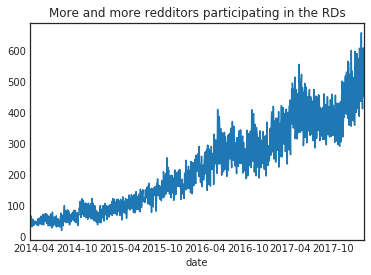

In [100]:
unique_authors = commentsDF[['date','author']].groupby('date').nunique()
unique_authors = unique_authors.drop('date', axis=1)
unique_authors.columns = ['unique_authors']

unique_authors.plot(title = 'More and more redditors participating in the RDs', legend = False)
plt.show()

Is there a steady stream of comments throughout the day? I bet not.

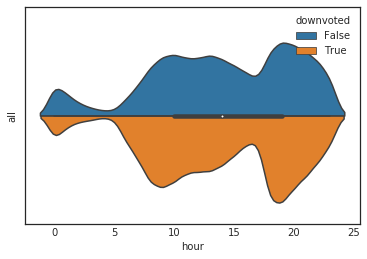

In [101]:
commentsDF['hour'] = pd.to_datetime(commentsDF['created'], unit='s').dt.hour
commentsDF['downvoted'] = (commentsDF['score'] < 0).astype('category')
commentsDF['all'] = ''

ax = sns.violinplot(data = commentsDF, y = 'all', x= 'hour'
                    , split = True, hue = 'downvoted',  bw = 0.1)


plt.show()

We can take a guess at an rPH RDer's day:

* 5AM - rise and RD!
* working hours - paid to RD
* around 3PM - oops I need to turn in _some_ work
* 6PM - off-work and RD
* around 11 pm - sleep?

(Assuming the overwhelming majority are posting from the Philippines, of course.)

Note that this violin plot is by posting hour, not voting hour. Also, the plot above is misleading because the downvoted distribution is inflated (not scaled to match count).  Let's look at the overall percentage of comments downvoted (taken here as negative score).

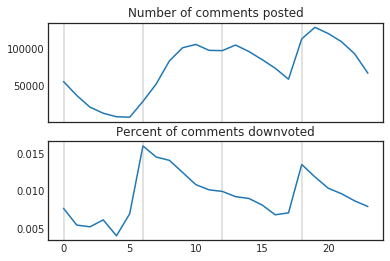

In [103]:
perc_downvoted = commentsDF[['downvoted', 'hour']].groupby('hour').sum() / commentsDF[['downvoted','hour']].groupby('hour').count()

fig, ax = plt.subplots(2,1, sharex = True)

ax[0].plot(commentsDF[['downvoted','hour']].groupby('hour').count())
ax[0].set_title('Number of comments posted')
ax[1].plot(perc_downvoted)
ax[1].set_title('Percent of comments downvoted')

for axis in ax:
    for i in [0,6,12,18]:
        axis.axvline(i, c = 'gray', alpha = 0.3)


Less than 2% of all comments are downvoted. The peaks correspond with the times the RD thread itself is posted(6AM and 6PM, but not 12NN and 12MN). Good to see the distribution and even better if we separate data into 1-RD, 2-RD and 4-RD period to clarify effects, if any.

Could be that at the start of the RD, a mix of upvote-y and downvote-y comments are posted as top level comments. The downvote-y comments posted early die naturally while the upvote-y ones get more replies which attract more upvotes (?) The RD is almost always sorted by New lately. Have to check if this applies to most RDs. Users could still be sorting by Best though, and there might be apps that change the deault sorting. 

In any case, let's try out different ways to visualize score distro.

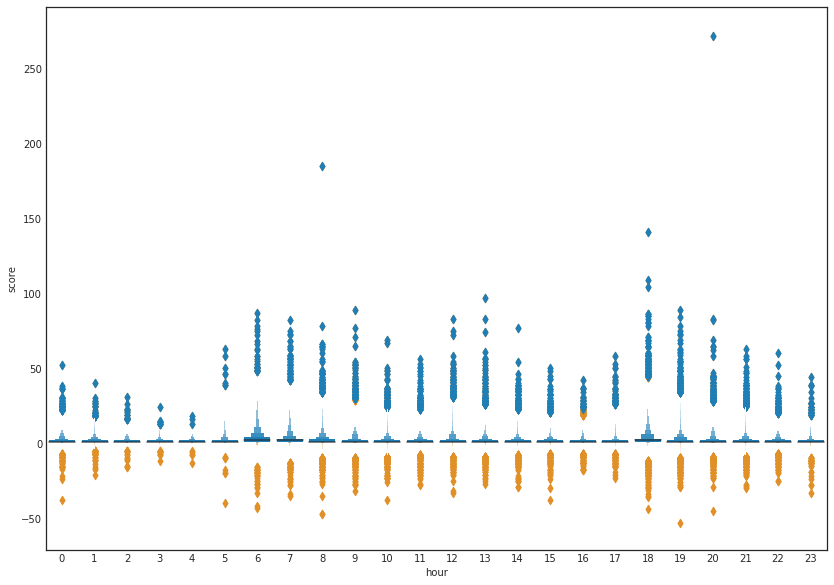

In [104]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.lvplot(ax = ax, data = commentsDF, y = 'score', x= 'hour',
           color = sns.xkcd_rgb["tangerine"],
          #dodge = False,
          #hue = 'downvoted',
         )

sns.lvplot(ax = ax, data = commentsDF[commentsDF['downvoted'] == False], y = 'score', x= 'hour',
           color = sns.xkcd_rgb["cerulean"],
          )
#ax.set_ylim(-10, 50)

plt.show()


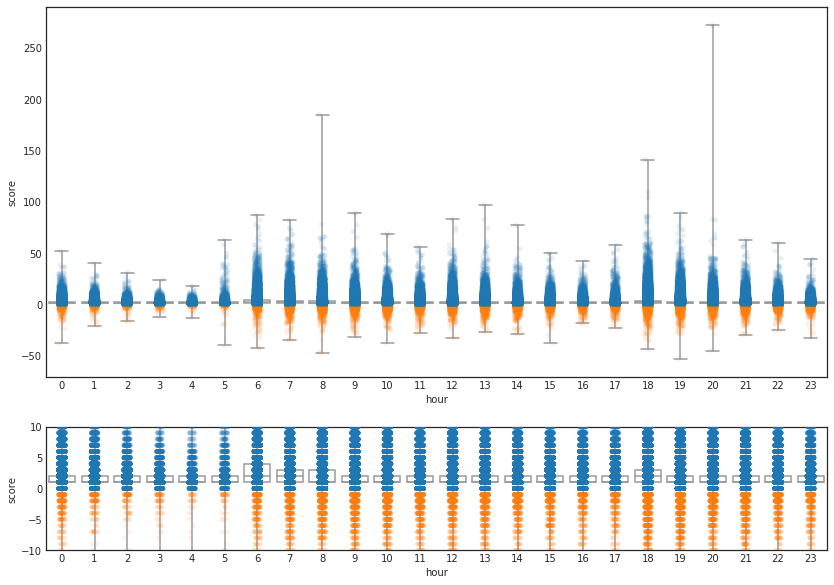

In [105]:
fig, ax = plt.subplots(2,1, figsize=(14, 10) , gridspec_kw = {'height_ratios':[3, 1]})
sns.stripplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
                   dodge = False, hue = 'downvoted',
                   alpha=0.1, jitter = True,
                  )
ax[0].legend_.remove()    
#ax[0].set_ylim(-50, 75)


sns.boxplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
            whis=np.inf,
            color = 'white',
           )

sns.stripplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
              dodge = False, hue = 'downvoted',
              alpha=0.1, jitter = True,
             )

ax[1].legend_.remove()
ax[1].set_ylim(-10, 10)

sns.boxplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
            whis=np.inf,
            color = 'white'
           )

plt.show()

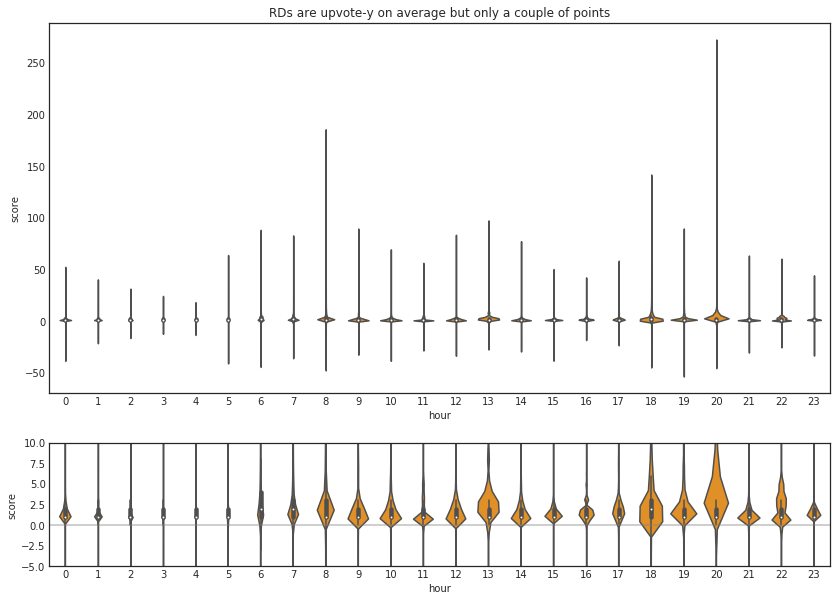

In [106]:
fig, ax = plt.subplots(2,1, figsize=(14, 10) , gridspec_kw = {'height_ratios':[3, 1]})
sns.violinplot(ax = ax[0], data = commentsDF, y = 'score', x= 'hour',
               scale = 'count',
              #dodge = False,
              #split = True,
              #hue = 'downvoted',
              #bw = 0.1,
               color = sns.xkcd_rgb["tangerine"],
              )
sns.violinplot(ax = ax[1], data = commentsDF, y = 'score', x= 'hour',
               scale = 'count',
              #dodge = False,
              #split = True,
              #hue = 'downvoted',
              #bw = 0.1,               
               color = sns.xkcd_rgb["tangerine"],
              )

ax[0].set_title('RDs are upvote-y on average but only a couple of points')
ax[1].set_ylim(-5, 10)
ax[1].axhline(0, c = 'gray', alpha = 0.5)

plt.show()

For karma (reddit reputation points) farming, larger audience size is desirable (assuming a more or less constant upvote-tendency). What we actually need to quantify 'audience' is the number of redditors reading the RD at a given time, but we don't have that. We can, however, look at the the number of redditors posting. 



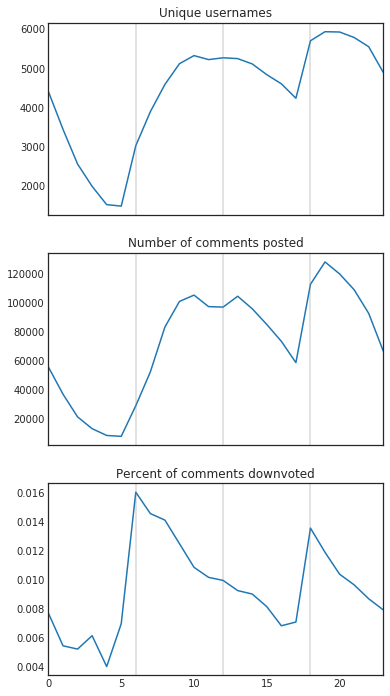

In [107]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

axarr[0].plot(commentsDF[['author','hour']].groupby('hour').nunique()['author'])
axarr[0].set_title('Unique usernames')

axarr[1].plot(commentsDF[['downvoted','hour']].groupby('hour').count())
axarr[1].set_title('Number of comments posted')

axarr[2].plot(perc_downvoted)
axarr[2].set_title('Percent of comments downvoted')

for ax in axarr:
    for i in [0,6,12,18]:
        ax.axvline(i, c = 'gray', alpha = 0.3)
        ax.set_xlim(0,23)


Oops, should we have taken the average per hour over days instead of total?

In [108]:
hourDF = pd.DataFrame()
hourDF['unique_authors'] = commentsDF[['author','date','hour']].groupby(['date','hour']).nunique()['author']
hourDF['n_comments'] = commentsDF[['author','date','hour']].groupby(['date','hour']).count()
commentsDF['downvoted'] = commentsDF['downvoted'].astype(bool)
hourDF['downvoted'] = commentsDF[['downvoted','date','hour']].groupby(['date','hour']).sum() 
hourDF['perc_downvoted'] = (hourDF['downvoted'] / hourDF['n_comments']).replace(np.inf, 0)
hourDF = hourDF.reset_index()
hourDF.head()

,date,hour,unique_authors,n_comments,downvoted,perc_downvoted
0,2014-03-12,1,1,2,0.0,0.0
1,2014-03-12,2,1,1,0.0,0.0
2,2014-03-12,3,1,2,0.0,0.0
3,2014-03-12,4,1,1,0.0,0.0
4,2014-03-12,5,2,4,0.0,0.0


In [109]:
hourDFp = hourDF.pivot(index = 'hour', columns= 'date').fillna(0)

base_colors = [sns.xkcd_rgb["cerulean"], sns.xkcd_rgb["tangerine"], sns.xkcd_rgb["pale red"]]
dark_colors = [sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["burnt orange"], sns.xkcd_rgb["burnt red"]]
columns = ['unique_authors', 'n_comments', 'perc_downvoted']
titles = ['Unique authors', 'Comments posted', 'Percent downvoted']

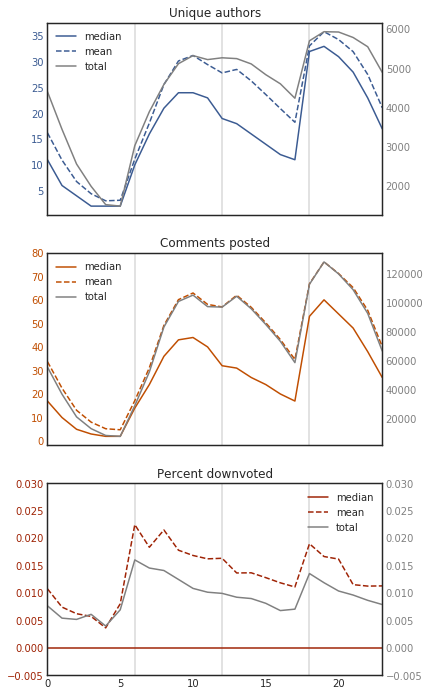

In [110]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

fig.set

for ax in axarr:
    for i in [0,6,12,18]:
        ax.axvline(i, c = 'gray', alpha = 0.3)

axt0 = axarr[0].twinx()
axt1 = axarr[1].twinx()
axt2 = axarr[2].twinx()

#ax1.get_shared_y_axes().join(ax1, ax3)

axt0.plot(commentsDF[['author','hour']].groupby('hour').nunique()['author'], c = 'gray', label = 'total')
axt1.plot(commentsDF[['downvoted','hour']].groupby('hour').count(), c = 'gray', label = 'total')
axt2.plot(perc_downvoted, c = 'gray', label = 'total')


for ax, col, title, color, axt in zip(axarr,columns,titles,dark_colors, [axt0,axt1,axt2]):
    ax.plot(hourDFp[col].median(axis=1), c = color, label = 'median')
    ax.plot(hourDFp[col].mean(axis=1), c = color, ls = '--', label = 'mean')
    ax.set_title(title)
    ax.set_xlim(0,23)  
    
    ax.tick_params('y', colors=color)
    axt.tick_params('y', colors='gray')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axt.get_legend_handles_labels()
    axt.legend(lines + lines2, labels + labels2, loc=0)
    

axarr[2].set_ylim(-0.005, 0.03)
axt2.set_ylim(-0.005, 0.03)
       
plt.show()

The overall trend for number of comments and unique users is the same, though the decrease in the afternoon is steeper when the median of the daily average is taken. The peak around noon is also lost. Perhaps the spike is due to the afternoon RD opening (there was no separate afternoon RD in the 'early days').

The percentage of comments downvoted is drastically different for mean and median. See distribution below.

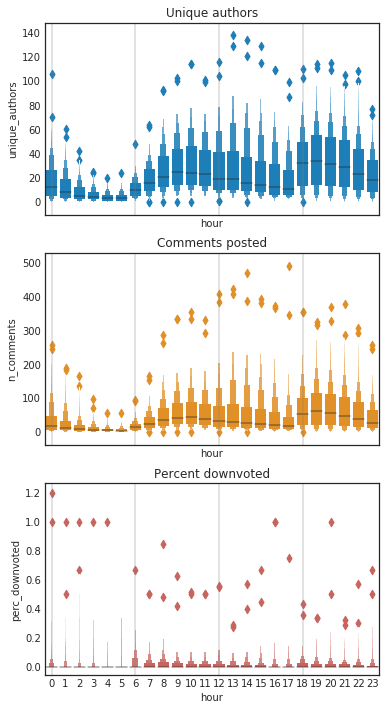

In [111]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(6, 12) )
plt.subplots_adjust(hspace=0.2)

for ax, col, title, color in zip(axarr,columns,titles,base_colors):
    sns.lvplot(ax = ax, data=hourDF, x = 'hour', y = col, color = color)
    ax.set_title(title)

for ax in axarr:
    for i in [0,6,12,18]:
         ax.axvline(i, c = 'gray', alpha = 0.3)


In the graph below, each line traces a specific date while the thicker line is the median. Seems like there are different modes of behavior (see two blue streams?) Must separate the 1-, 2- and 4-RD periods. 

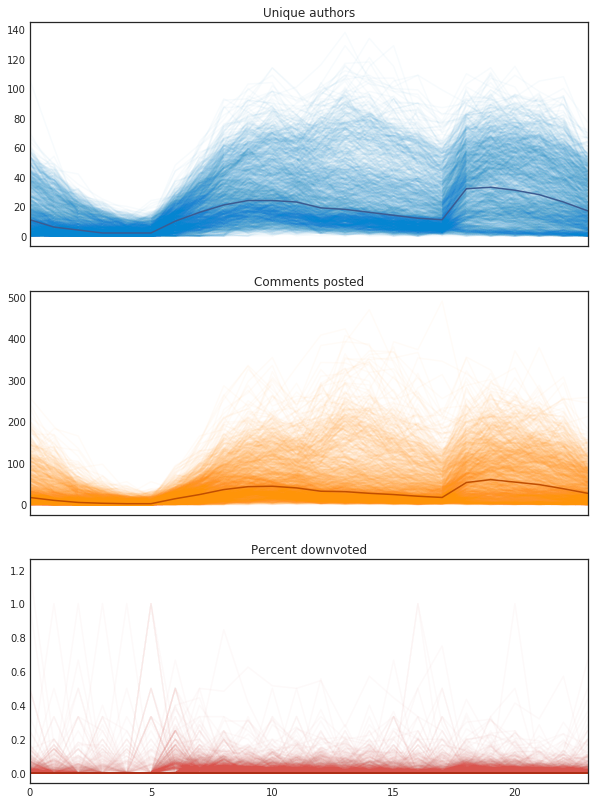

In [112]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(10, 14) )
plt.subplots_adjust(hspace=0.2)


for ax, col, title, color1, color2 in zip(axarr,columns,titles,base_colors,dark_colors):

    ax.plot(hourDFp[col], alpha = 0.03, c = color1)
    ax.plot(hourDFp[col].median(axis=1), c = color2)
    ax.set_title(title)
    ax.set_xlim(0,23)

plt.show()


Separating the  1-, 2- and 4-RD periods reveal that posting behavior has changed along with the number of RDs per day. 

In [113]:
oneRDend = pd.to_datetime('2014-10-09')
twoRDend = pd.to_datetime('2017-04-07')
fourRDend = hourDFp['n_comments'].columns.max()

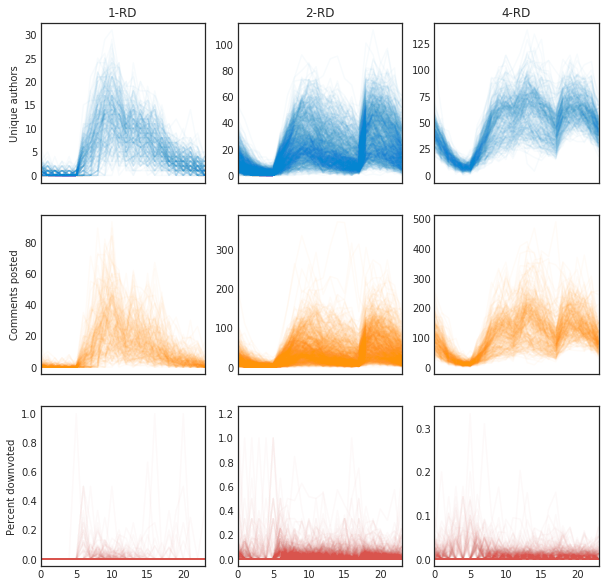

In [114]:
fig, axarr = plt.subplots(3,3, sharex = True, figsize=(10, 10),
                      #sharey = 'row', 
                      )
plt.subplots_adjust(hspace=0.2)

for i,col,title,color in zip(range(3),columns, titles, base_colors):
    axarr[i,0].plot((hourDFp[col].T)[inception:oneRDend].T, alpha = 0.03, c = color)
    axarr[i,1].plot((hourDFp[col].T)[oneRDend+timedelta(days=1):twoRDend].T, alpha = 0.03, c = color)
    axarr[i,2].plot((hourDFp[col].T)[twoRDend+timedelta(days=1):fourRDend].T, alpha = 0.03, c = color)
    axarr[i,0].set_ylabel(title)
    plt.xlim(0,23)
    
axarr[0,0].set_title('1-RD')
axarr[0,1].set_title('2-RD')
axarr[0,2].set_title('4-RD')

plt.show()

Counterpoint: Or was the behavior already changing and the RD split was an adaptation?

In [115]:
#plot with slider for date

So what time and day is it a good time to post for greater visibility, now that we know behavior is different for the 4-RD period? 

In [116]:
hourDF['dayofweek'] = pd.to_datetime(hourDF['date']).dt.dayofweek

Let's focus on the 4-RD period.

In [117]:
dowAVE = hourDF[hourDF['date'] > twoRDend.date()].drop('date',axis=1).groupby(['dayofweek','hour']).mean()
dowAVE = dowAVE.unstack()
dowAVE.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

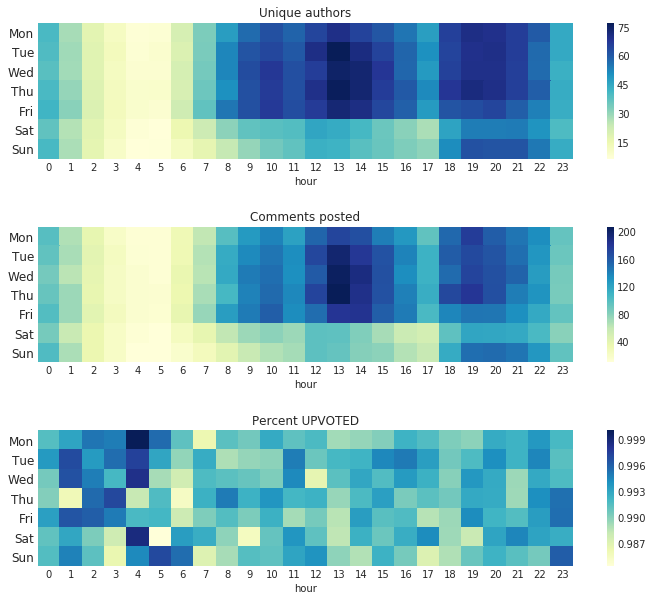

In [118]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(12, 10)
                      # , sharey = 'row' 
                      )
plt.subplots_adjust(hspace=0.5)

sns.heatmap(dowAVE['unique_authors'], ax = axarr[0],cmap="YlGnBu")
axarr[0].set_title('Unique authors')

sns.heatmap(dowAVE['n_comments'], ax = axarr[1], cmap="YlGnBu")
axarr[1].set_title('Comments posted')

# For visual consistency of 'desireable areas', plot percent upvoted
sns.heatmap(1 - dowAVE['perc_downvoted'], ax = axarr[2], cmap="YlGnBu")
axarr[2].set_title('Percent UPVOTED')

for ax in axarr:
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)

The percent of downvoted comments (or upvoted comments in this case) may just be a matter of downvoted comments being diluted by more comments during that hour. Anyway, the difference is quite small.

For a wider audience, post 1PM on a weekday. Seems like RD-ers have some semblance of real-world Friday nightlife and are otherwise occupied on weekends.

In contrast, see the heatmaps for all periods.

In [119]:
dowAVE = hourDF.drop('date',axis=1).groupby(['dayofweek','hour']).mean()
dowAVE = dowAVE.unstack()
dowAVE.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

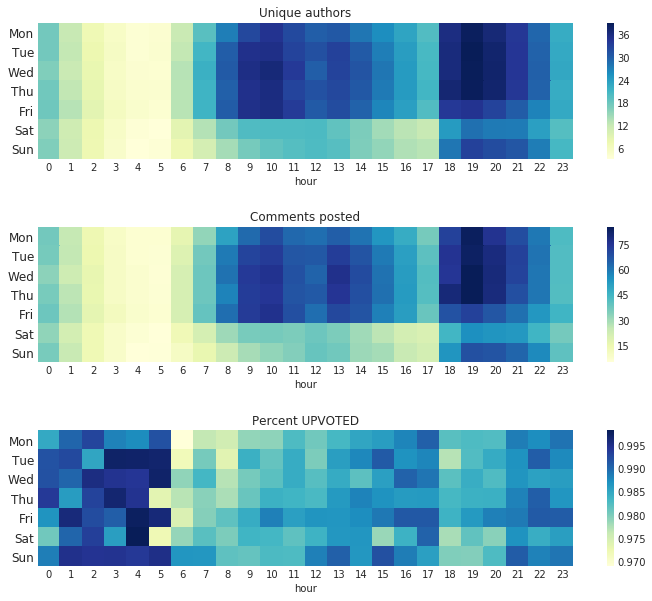

In [120]:
fig, axarr = plt.subplots(3,1, sharex = True, figsize=(12, 10)
                      # , sharey = 'row' 
                      )
plt.subplots_adjust(hspace=0.5)

sns.heatmap(dowAVE['unique_authors'], ax = axarr[0],cmap="YlGnBu")
axarr[0].set_title('Unique authors')

sns.heatmap(dowAVE['n_comments'], ax = axarr[1], cmap="YlGnBu")
axarr[1].set_title('Comments posted')

# For visual consistency of 'desireable areas', plot percent upvoted
sns.heatmap(1 - dowAVE['perc_downvoted'], ax = axarr[2], cmap="YlGnBu")
axarr[2].set_title('Percent UPVOTED')

for ax in axarr:
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)

### Ang Pinaka

In [121]:
print('TOP SCORING POSTS\n')
top10score = (commentsDF.sort_values('score', ascending = False))[['author','body', 'score']].head(10)

for i in range(3):
    print('************\nAt # {} with {} points by u/{}:\n {}\n'.format(i+1, top10score['score'][i],
                                                         top10score['author'][i], top10score['body'][i]))

TOP SCORING POSTS

************
At # 1 with 272 points by u/PM_M3_YOUR_PA55WORD:
 Kanina sa office, kinwento ko sa officemates ko na nanood ako ng Coco nang mag-isa and my office mate said that he's going to watch it alone tomorrow. Another office mate then replied, *"Bakla ka ba? Maghahanap ka ng booking sa sinehan? Mga bakla lang daw usually nanonood ng sine mag-isa. Hahaha."* in a snark tone. I wanted to snap back at his remark, but I couldn't. People like him are the reason I still don't want to come out. 

This guy also happens to be a low-key DDS. I also heard him say, *"Sana taasan yung pamasahe sa MRT para hindi na makasakay yung mga mahihirap."* Kung di lang sana 'to malaking tao, matagal ko nang inaway. Tangina mo Aldrin.

************
At # 2 with 185 points by u/_IchigoIchie:
 5 years ago, we had a new hire who latter joined my Team in which I have to supervise. The nature of our work involves minor programming and conducting client visit to train and present our product. We

Let's create a new dataframe for user-based stats.

In [122]:
print('There are {} comments with null authors (deleted accounts)'.format(commentsDF['author'].isnull().sum()))

There are 266577 comments with null authors (deleted accounts)


Groupby automatically ignores null values.

In [123]:
redditorsDF = commentsDF[['author','score', 'gilded', 'depth']].groupby('author').sum()
redditorsDF['n_comments'] = commentsDF[['author','score']].groupby('author').count()
redditorsDF = redditorsDF.rename(columns={'score': 'total_score', 
                                           'gilded':'total_gilded', 
                                           'depth':'total_depth'})
redditorsDF.head()

,total_score,total_gilded,total_depth,n_comments
author,,,,
--FinAlize,69,0,41,31
--KuyaJ_,3,0,1,1
-01123581321345589-,65,0,55,28
-3005,2,0,0,2
-Aldrin-,11,0,10,5


We can easily show who has received the most reddit gold. 

In [124]:
print('MOST GILDED')
redditorsDF.sort_values('total_gilded', ascending = False)[['total_gilded', 'n_comments']].head(10)

MOST GILDED


,total_gilded,n_comments
author,,
psst-got-real,4,3556
murse_with_moobs,4,5487
Un1t-X,3,1211
NotAikoYumi,3,15534
mitselschisels,3,2878
Potatina,3,518
misschurros,3,4345
cardboardbuddy,2,8536
SongstressInDistress,2,3916


We'll also create another DF broken down by day to get a profile of which users are active per day. Not looking at per RD here, since there are days with 1 or 2 or 4 RDs. This way, users can participate in one or a few RDs and count as active. (Though some may be active in all RDs! They call themselves no-lifers :p Participants live in different timezones, too.)

In [125]:
dailyDF = commentsDF[['date','author','score']].groupby(['date','author']).count()
dailyDF = dailyDF.rename(columns = {'count':'n_comments'})
dailyDF = dailyDF.unstack(fill_value = 0)
dailyDF.columns = dailyDF.columns.get_level_values(1)
dailyDF.head()

author,--FinAlize,--KuyaJ_,-01123581321345589-,-3005,-Aldrin-,-And-Peggy-,-Blitzen,-Bughaw-,-ELJuicyBacon,-EdoTensei,-Estupida-,-GCF,-Guernica,-HuggyBear-,-Kuya,-La_Geass-,-Paranoia,-RailGun-,-RememberMe-,-SexyBeast,-Throw_Away_Account-,-Zeeero,-bbustanutt-,-crypticpattern,-essi-,-ffffff,-flyhigh-,-habagat-chick-,-hello_world_,-hellogoodbye,-inator,-kindakrazy-,-leloo-,-lightfury-,-mayumi-,-memento-mori,-mr-throwaway-,-ob1,-ph0enix-,-tRabbit,-thatswhatshesaid,-the_yaya,-trowawaybarton,-tukso-,-violette-,-zonrox-,00000_,0010001_1,00327AA343,00o0o00,01001010_01001101,0101001001110010043N,01011000X,011418,01189998819991197tu5,013V34,01cabeliza,01geli,022890,0304slurpee,033054,0819-,092284,09262225422,0927123,0934230,0Leviathan0,0detosleep,0egg,0foxdec,0kills,0ldg0ld,0scar-kil0,0xsherwin,0yen,1-800-Pi,1000pain,10071595,100789,100one,101010anon,1011pm,1063526266327193,10747788,10YearsANoob,1111241111,1111eleveneleven,1111hyong,11212212,1127bolivar,11548361,11_19khad,11thplace,1216996,123089dc,12313132344324345353,123AsawaNiMarie,123choji,123ketchup,12curtainz,...,yuhnduh,yuhtalaga,yui_baby,yumicecream,yummygummytummy,yummypunani,yuneedan,yunipay,yuppiyuo,yurilith,yurinforit,yuuranni,yuzucchi,yyedditt,yzarcyeknom,z3rb,zEno_17,zEvilGuy,zSuicideSheep,zaaanovavitch,zaba_prince,zamanyly,zandrach,zanezki,zao_meshikov,zapxcero,zariazelle,zatannaa,zboltz,zdc21,zddie,zealotofcynicism,zeapple,zedfrostxnn,zeeeguy,zeekers05,zeethezee,zehkee,zeitgeist_139,zekecahill,zekester10,zen970804,zenCompiler,zenerd1ode,zenithisland,zenkkai2,zenofthefuries,zenzenhyun,zephyrain,zephyrino_,zer0wl,zeroeightviii,zeromaya,zerouji,zerrypie,zeseries,zeuxisz,zhern012,zhern01234,zhytwos,ziaddaiz,zielbertryle,zigzagzig,zikomocd,zilt0ide,zilvertear,zioure,zipitfast,zipperzapper,zizzle-stick,zjhun,zjomea,zjzr_08,zkere,zoldyckbaby,zomNick,zombiebabe4eva,zoned_tider,zonickxxx,zonrox,zoominfeature,zsazsaZaturnnah,ztac_dex,ztgl,zurc_melanion,zuvawa,zweiarmer,zweisswrites,zwenzens,zwreid,zxccxzz,zxwx,zygrush,zyphoxan,zyphyrkhyts,zypros026,zywin_lannister,zz_zzz,zzz_coder,zzzss
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-03-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-03-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [126]:
redditorsDF['days_present'] = (dailyDF > 0).sum()
redditorsDF.head()

,total_score,total_gilded,total_depth,n_comments,days_present
author,,,,,
--FinAlize,69,0,41,31,8
--KuyaJ_,3,0,1,1,1
-01123581321345589-,65,0,55,28,9
-3005,2,0,0,2,2
-Aldrin-,11,0,10,5,2


How do we define top users? One way would be to look at who has posted the most number of comments so far. Another would be to look at who has been active the most days since the RDs started. Note that newer users are 'disadvantaged' under this definition because they don't have time on their side.

In [127]:
most_comments_all_time = redditorsDF.sort_values('n_comments', ascending = False).head(10).index.values
most_comments_all_time

array(['Fulltergeist', 'NotAikoYumi', 'Mr_Connie_Lingus69', 'Pasencia',
       'FecklessFool', 'toshi04', 'cardboardbuddy', 'Aeronautique_F',
       'sakundes', 'thenameisgsarci'], dtype=object)

In [128]:
most_active_all_time = redditorsDF.sort_values('days_present', ascending = False).head(10).index.values
most_active_all_time

array(['toshi04', 'the_yaya', 'blackcoffin90', 'hellotheremiss',
       'evilphotosynthesis', 'pintasero', 'MeepXD', 'decayedramen',
       'gingangguli', 'scubadance'], dtype=object)

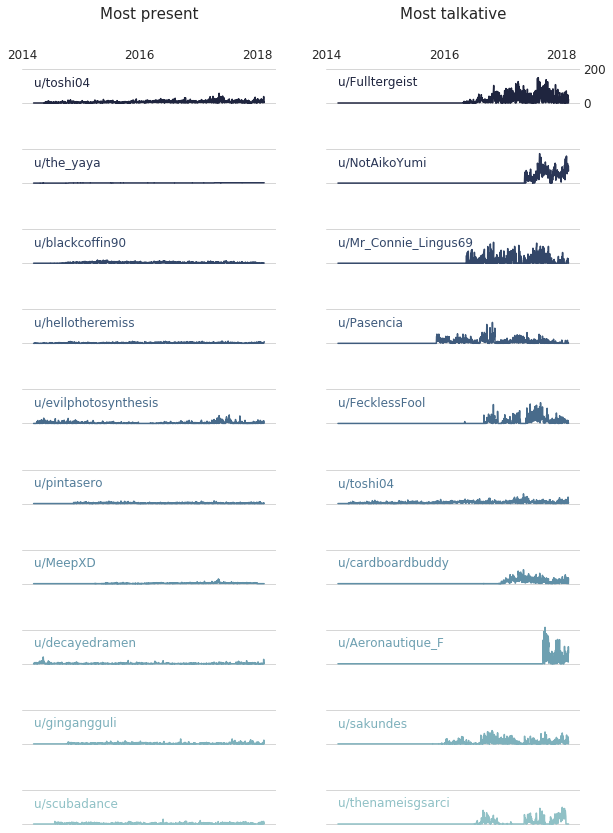

In [129]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)[::-1]
    
years = mdates.YearLocator(2)   # every other year
yearsFmt = mdates.DateFormatter('%Y')

f, axarr = plt.subplots(10, 2, sharex=True, sharey=True, figsize=(10, 14))
plt.subplots_adjust(hspace=1, wspace = 0.2)

top_users = [most_active_all_time, most_comments_all_time]

for i in range(2):
    
    for ax, user, color in zip(axarr.T[i], top_users[i], pal):
        
        ax.plot(dailyDF.index, dailyDF[user], c = color)
        ax.set_frame_on(False)
        #ax.grid(False)
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)    
        ax.tick_params(axis='both',labelleft='off', labeltop='off', labelright='off', labelbottom='off')
        ax.text(dailyDF.index[0], 100, 'u/{}'.format(user), 
                     {'fontsize': 12,
                      'horizontalalignment': 'left',
                      'color': color},
                )
    
    
    
axarr[0,0].set_title('Most present', y = 2, fontsize = 15 )    
axarr[0,0].tick_params(axis='x', labelleft='off', labeltop='on', labelright='off', labelbottom='off', labelsize = 12)

axarr[0,1].set_title('Most talkative', y = 2, fontsize = 15 )
axarr[0,1].tick_params(axis='y', labelleft='off', labeltop='off', labelright='on', labelbottom='off', labelsize = 12)
axarr[0,1].tick_params(axis='x', labelleft='off', labeltop='on', labelright='off', labelbottom='off', labelsize = 12)




From the right-hand-side panel, we observe that some redditors were 'late to the party' so to speak, but once they got in, they talked up a storm! Others, like u/toshi04 have a slow-but-steady type of approach.

We'll use the term 'age' to denote the number of days since a particular redditor started posting. 

One metric we can consider is presence rate. We can take the number of days a redditor participated in any RD of the day over (a) all the possible days s/he could have participated since she first posted in the RD ('age'), or (b) all the days in which s/he was active (s/he could have stopped participating after some date). But (b) is problematic if we consider redditors who only posted once the entire time. That redditor's presence rate will be a perfect 1! (a) is also problematic because now, 'younger' redditors have unfair advantage (e.g. I started posting yesterday so I have 100% presence rate)


In [130]:
tempDF = dailyDF.T > 0
cols = tempDF.columns
tempDF = tempDF.apply(lambda x: list(cols[x.values]), axis=1)
redditorsDF['first_post_date'] = tempDF.apply(lambda x: min(x))
redditorsDF['last_post_date'] = tempDF.apply(lambda x: max(x))
redditorsDF['days_active'] = (redditorsDF['last_post_date'] - redditorsDF['first_post_date']).dt.days + 1
redditorsDF['age_in_days'] = (dailyDF.index.max() - redditorsDF['first_post_date']).dt.days + 1
redditorsDF['presence_rate_since_birth'] = redditorsDF['days_present'] / redditorsDF['age_in_days'] 
redditorsDF['presence_rate_while_active'] = redditorsDF['days_present'] / redditorsDF['days_active']
print('Total number of RD participants: {}'.format(redditorsDF.shape[0]))
redditorsDF.head()

Total number of RD participants: 15067


,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active
author,,,,,,,,,,,
--FinAlize,69,0,41,31,8,2017-09-08,2018-02-01,147,158,0.050633,0.054422
--KuyaJ_,3,0,1,1,1,2018-02-11,2018-02-11,1,2,0.500000,1.000000
-01123581321345589-,65,0,55,28,9,2016-10-26,2017-03-19,145,475,0.018947,0.062069
-3005,2,0,0,2,2,2016-06-20,2016-07-16,27,603,0.003317,0.074074
-Aldrin-,11,0,10,5,2,2017-12-04,2017-12-05,2,71,0.028169,1.000000


A lot are hit-and-run.

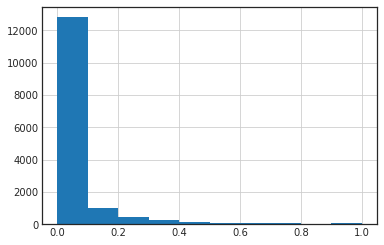

In [131]:
redditorsDF['presence_rate_since_birth'].hist()

A histogram of presence_rate_while_active indicates many of these hit-and-runners may be once-and-never-again-ers (OANAs), instead of being infrequent posters. Could be casuals or throwaways (accounts used for posting once or a few times and discarded).

5544 participants appear once and never again.


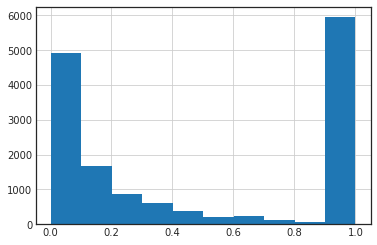

In [132]:
redditorsDF['presence_rate_while_active'].hist()

print('{} participants appear once and never again.'.format((redditorsDF['days_active'] == 1).sum()))

OANA count seems to be increasing lately.

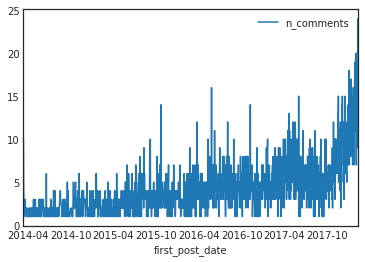

In [133]:
OANAs = redditorsDF[redditorsDF['days_present'] == 1].index
nonOANAs = redditorsDF[redditorsDF['days_present'] > 1].index
redditorsDF.loc[OANAs][['first_post_date', 'n_comments']].groupby('first_post_date').count().plot()
plt.show()

Can OANAs account for increase in unique users?

In [134]:
###


If we plot date of last post versus date of first post, the diagonal will be populated by users who only posted once. The top part will be populated by users who are still active (or recently active). Each point is a user and the size of the point is proportional to the total number of comments made by the user. 


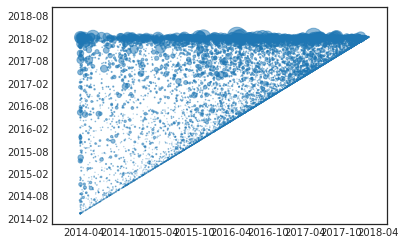

In [135]:
first_dates = pd.to_datetime(redditorsDF['first_post_date']).values
last_dates = pd.to_datetime(redditorsDF['last_post_date']).values

plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments']/50, alpha= 0.5)

plt.show()

Let's try number of comments per day since first post. The top redditors here would be those who started and chatted the most since then. Interestingly, they have perfect attendance (from since they enrolled)! 

In [137]:
redditorsDF['n_comments_per_day_since_birth'] = redditorsDF['n_comments'] / redditorsDF['age_in_days'] 
redditorsDF['n_comments_per_day_while_active'] = redditorsDF['n_comments'] / redditorsDF['days_active']
redditorsDF.sort_values('n_comments_per_day_since_birth', ascending = False).head()

,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active,n_comments_per_day_since_birth,n_comments_per_day_while_active
author,,,,,,,,,,,,,
CaseHills,311,0,262,138,1,2018-02-12,2018-02-12,1,1,1.000000,1.000000,138.000000,138.000000
Rav_Fontanilla,9345,1,15686,5253,38,2018-01-04,2018-02-12,40,40,0.950000,0.950000,131.325000,131.325000
NotAikoYumi,33390,3,35798,15534,265,2017-05-15,2018-02-12,274,274,0.967153,0.967153,56.693431,56.693431
Aeronautique_F,17406,1,22305,8491,143,2017-09-06,2018-02-12,160,160,0.893750,0.893750,53.068750,53.068750
ChinChunSu,7125,2,5956,2664,59,2017-12-16,2018-02-12,59,59,1.000000,1.000000,45.152542,45.152542


In [138]:
redditorsDF['n_comments_per_day_since_birth'].describe()

count    15067.000000
mean         0.321529
std          2.192572
min          0.000697
25%          0.004261
50%          0.019391
75%          0.113208
max        138.000000
Name: n_comments_per_day_since_birth, dtype: float64

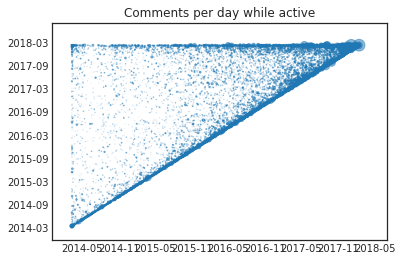

In [139]:
plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments_per_day_while_active'], alpha= 0.5)
plt.title('Comments per day while active')
plt.show()

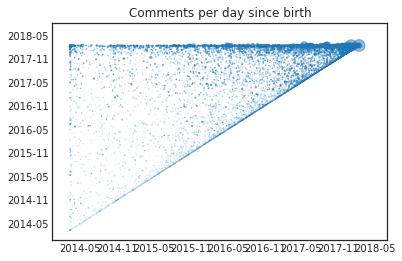

In [140]:
plt.scatter(x = first_dates, y = last_dates, s = redditorsDF['n_comments_per_day_since_birth'], alpha= 0.5)
plt.title('Comments per day since birth')
plt.show()

The 'ideal' RD redditor would be one who has been posting since inception and posting a lot per day since then (top left corner). The other end of the spectrum would be someone who is new and rarely posts. Let's define a metric 'rating' which (for now) naively takes the product of these two factors. The higher this metric is, the 'better' the redditor.

In [143]:
tempDF = redditorsDF[['n_comments_per_day_since_birth','age_in_days']]
scaler = preprocessing.MinMaxScaler()
scaledDF = scaler.fit_transform(tempDF)
scaledDF = pd.DataFrame(scaledDF, columns=['n_comments_per_day_since_birth','age_in_days'], index = tempDF.index)
redditorsDF['rating'] = scaledDF['n_comments_per_day_since_birth'] * scaledDF['age_in_days']

redditorsDF.sort_values('rating', ascending = False).head(10)

,total_score,total_gilded,total_depth,n_comments,days_present,first_post_date,last_post_date,days_active,age_in_days,presence_rate_since_birth,presence_rate_while_active,n_comments_per_day_since_birth,n_comments_per_day_while_active,rating
author,,,,,,,,,,,,,,
Fulltergeist,39589,2,38675,19181,558,2016-04-29,2018-02-12,655,655,0.851908,0.851908,29.283969,29.283969,0.096844
NotAikoYumi,33390,3,35798,15534,265,2017-05-15,2018-02-12,274,274,0.967153,0.967153,56.693431,56.693431,0.078265
Mr_Connie_Lingus69,16634,0,28718,11799,416,2016-05-18,2018-02-12,636,636,0.654088,0.654088,18.551887,18.551887,0.059569
Pasencia,17073,0,20587,10372,664,2015-11-14,2018-02-12,822,822,0.807786,0.807786,12.618005,12.618005,0.052383
FecklessFool,20535,1,19646,9922,440,2016-05-07,2018-02-12,647,647,0.680062,0.680062,15.335394,15.335394,0.050094
toshi04,18265,0,14651,9176,1248,2014-05-14,2018-02-12,1371,1371,0.910284,0.910284,6.692925,6.692925,0.046363
cardboardbuddy,22926,2,17913,8536,411,2016-09-03,2018-02-12,528,528,0.778409,0.778409,16.166667,16.166667,0.043081
Aeronautique_F,17406,1,22305,8491,143,2017-09-06,2018-02-12,160,160,0.893750,0.893750,53.068750,53.068750,0.042668
sakundes,13890,1,17111,8335,480,2015-10-22,2018-02-12,845,845,0.568047,0.568047,9.863905,9.863905,0.042096


The number of comments is so skewed that it completely dominated the trend. 

The same members? True


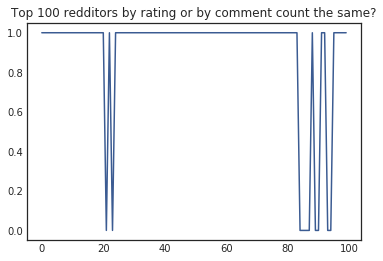

In [145]:
redditors_by_rating = redditorsDF.sort_values('rating', ascending = False).index.values
redditors_by_ncomments = redditorsDF.sort_values('n_comments', ascending = False).index.values

top_n = 100
plt.plot((redditors_by_rating == redditors_by_ncomments)[:top_n].astype(int), c = dark_colors[0])
plt.title('Top {} redditors by rating or by comment count the same?'.format(top_n))
print('The same members? {}'.format(set(redditors_by_rating[:top_n]) == set(redditors_by_ncomments[:top_n])))
plt.show()

The ordering may change but the top 100 has the same usernames.

In [146]:
for i in range(10):
     print ('{}: {} vs {}'.format(i + 1,
                                 redditors_by_rating[i],
                                 redditors_by_ncomments[i])
           )

1: Fulltergeist vs Fulltergeist
2: NotAikoYumi vs NotAikoYumi
3: Mr_Connie_Lingus69 vs Mr_Connie_Lingus69
4: Pasencia vs Pasencia
5: FecklessFool vs FecklessFool
6: toshi04 vs toshi04
7: cardboardbuddy vs cardboardbuddy
8: Aeronautique_F vs Aeronautique_F
9: sakundes vs sakundes
10: thenameisgsarci vs thenameisgsarci


Maybe we can also look at who has the highest average score. But in this case, users with only a few high scoring posts will dominate, even though they rarely participate in the RDs (mostly OANAs). 

In [147]:
redditorsDF['ave_score'] = redditorsDF['total_score'] / redditorsDF['n_comments']
redditorsDF.sort_values('ave_score', ascending=False)[['ave_score', 'n_comments']].head(10)

,ave_score,n_comments
author,,
BloodSweatTears18M,53.0,1
Nico-Nii_Nico-Chan,43.0,1
Kung-Fu-Dugong,41.0,1
NJNetsFan5152433,40.5,2
thr0w4w4y456,40.0,1
namdrizal,39.0,1
noypikadiri,38.5,2
alalako,35.0,1
anticorruptionman,33.0,1


In [149]:
print('Half of the accounts totaled {} posts.'.format(redditorsDF['n_comments'].median()))

Half of the accounts totaled 6.0 posts.


It might be better to calculate a confidence interval for the mean score and take, say, the lower bound of that as as 'rating'? 

For authors with a lot of comments, the distribution looks positively skewed. 

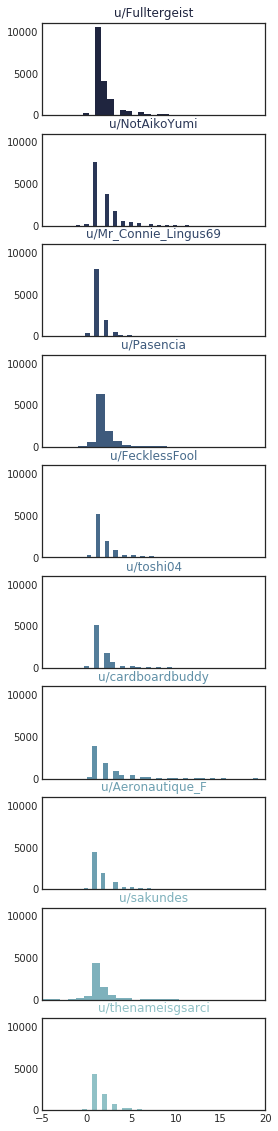

In [151]:
f, axarr = plt.subplots(10, 1, sharex=True, sharey=True, figsize=(4, 20))
plt.subplots_adjust(hspace=0.2, )

for ax, author, color in zip(axarr, most_comments_all_time, pal):
    ax.hist(commentsDF[commentsDF['author'] == author]['score'], bins = 100, color = color)
    ax.set_xlim(-5, 20)
    #ax.grid(False)dist = ss.t.ppf(0.975, df.shape[1]-1) * df.sem(axis=1)
    ax.set_title('u/{}'.format(author), 
                 {'fontsize': 12,
                  'horizontalalignment': 'center',
                  'color': color},
            )


Let's calculate the confidence interval for the mean of a user's score and limit to those with more than 30 posts.

In [155]:
ciDF = commentsDF[['author','score']].groupby('author').sem() 
ciDF.columns = ['sem']
ciDF['n'] = redditorsDF['n_comments']
ciDF['h'] = ss.t.ppf(0.975, ciDF['n']-1)
ciDF['mean'] = commentsDF[['author','score']].groupby('author').mean() 
ciDF ['lowerbound'] = ciDF['mean'] - (ciDF['h'] * ciDF['sem'])

redditorsDF['lb_score'] = ciDF['lowerbound']#.fillna(0) 
ciDF = ciDF[ciDF['n'] > 30]

In [156]:
ciDF.describe()

,sem,n,h,mean,lowerbound
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,0.228318,361.281701,1.988082,1.997383,1.541169
std,0.199728,868.378273,0.023417,0.651959,0.563761
min,0.000000,31.000000,1.960088,-6.648649,-9.829450
25%,0.109034,56.000000,1.967930,1.622457,1.279974
50%,0.177739,115.000000,1.980992,1.885714,1.505012
75%,0.281794,300.000000,2.004045,2.244138,1.776534
max,4.592117,19181.000000,2.042272,9.203390,4.838041


In [157]:
ciDF.sort_values('lowerbound', ascending=False).head(20)

,sem,n,h,mean,lowerbound
author,,,,,
ilongderanger,0.241937,738,1.963188,5.313008,4.838041
joshuagapaz,0.929752,55,2.004879,6.581818,4.717778
blue_fluffy_pillows,1.496713,81,1.990063,7.469136,4.490582
FashionPulisBot,0.211968,149,1.976122,4.832215,4.413340
momonyak,0.625866,84,1.988960,5.654762,4.409940
missjanedoeeyes,0.399469,191,1.972528,4.874346,4.086382
well_it_looks_like,0.836274,175,1.973691,5.617143,3.966596
snippetfactory,0.531753,31,2.042272,5.032258,3.946274
blackeeyedpanda,0.576631,39,2.024394,5.076923,3.909595


Can we cluster participants into some interpretable groups?

In [ ]:
###

In [ ]:
cols_to_pplot = ['ave_score', 
                 #'lb_score', 
                 'total_gilded', 'n_comments', 'days_present', 'days_active', 'age_in_days']
sns.pairplot(redditorsDF[cols_to_pplot]#.dropna()
            )

Notes from the pairplot:
* days_active vs ave score: most polarizing are OANAs?
* n_comments vs ave score: those who post a lot still mostly average 0.
* ave_score hist: RDs are more upvote-y than downvote-y
* ...

    

### To do:

* extract redditor info from profile

* graph of who replies to whom the most - cliques? -- need to redownload but different form

* predict upvoted? predict gilded? maximize score? consider word count, posting time, sentiment

* top words/word cloud

* detect a meme and create an ootl bot

* imitate top posters

* interactive plots for users to locate themselves

